Let's load the Kaggle dataset with API and extract all the zip files.

In [27]:
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import ReduceLROnPlateau
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

for dirname, _, filenames in os.walk('/content/drive/My Drive/Data 2040 Midterm Project/data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/My Drive/Data 2040 Midterm Project/data/class_map.csv
/content/drive/My Drive/Data 2040 Midterm Project/data/test_image_data_0.parquet
/content/drive/My Drive/Data 2040 Midterm Project/data/sample_submission.csv
/content/drive/My Drive/Data 2040 Midterm Project/data/test.csv
/content/drive/My Drive/Data 2040 Midterm Project/data/test_image_data_1.parquet
/content/drive/My Drive/Data 2040 Midterm Project/data/test_image_data_2.parquet
/content/drive/My Drive/Data 2040 Midterm Project/data/test_image_data_3.parquet
/content/drive/My Drive/Data 2040 Midterm Project/data/train_image_data_0.parquet
/content/drive/My Drive/Data 2040 Midterm Project/data/train_image_data_1.parquet
/content/drive/My Drive/Data 2040 Midterm Project/data/train_image_data_2.parquet
/content/drive/My Drive/Data 2040 Midterm Project/data/train_image_data_3.parquet
/content/drive/My Drive/Data 2040 Midterm Project/data/train.csv


In [0]:
#pip uninstall tensorflow

In [0]:
#pip install tensorflow==1.5.0

In [0]:
def identity_block(X, f, filters, stage, block):
  """
  ResNet Identity block

  Arguments:
  X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
  f -- integer, specifying the shape of the middle CONV's window for the main path
  filters -- python list of integers, defining the number of filters in the CONV layers of the main path
  stage -- integer, used to name the layers, depending on their position in the network
  block -- string/character, used to name the layers, depending on their position in the network

  Returns:
  X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
  """

  # defining name basis
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  # Retrieve Filters
  F1, F2, F3 = filters

  # Save the input value. You'll need this later to add back to the main path. 
  X_shortcut = X

  # First component of main path
  X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
  X = Activation('relu')(X)

  # Second component of main path
  X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
  X = Activation('relu')(X)

  # Third component of main path
  X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

  # Final step: Add shortcut value to main path, and pass it through a RELU activation
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X

In [0]:
def convolutional_block(X, f, filters, stage, block, s=2):
  """
  Implementation of the convolutional block

  Arguments:
  X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
  f -- integer, specifying the shape of the middle CONV's window for the main path
  filters -- python list of integers, defining the number of filters in the CONV layers of the main path
  stage -- integer, used to name the layers, depending on their position in the network
  block -- string/character, used to name the layers, depending on their position in the network
  s -- Integer, specifying the stride to be used

  Returns:
  X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
  """

  # defining name basis
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  # Retrieve Filters
  F1, F2, F3 = filters

  # Save the input value
  X_shortcut = X

  ##### MAIN PATH #####
  # First component of main path 
  X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
  X = Activation('relu')(X)

  # Second component of main path
  X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
  X = Activation('relu')(X)

  # Third component of main path
  X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

  ##### SHORTCUT PATH ####
  X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
  X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

  # Final step: Add shortcut value to main path, and pass it through a RELU activation
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X

In [0]:
def ResNet50(input_shape=(64, 64, 1), classes=6):
  """
  Implementation of the popular ResNet50 the following architecture:
  CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
  -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

  Arguments:
  input_shape -- shape of the images of the dataset
  classes -- integer, number of classes

  Returns:
  model -- a Model() instance in Keras
  """

  # Define the input as a tensor with shape input_shape
  X_input = Input(input_shape)

  # Zero-Padding
  X = ZeroPadding2D((3, 3))(X_input)

  # Stage 1
  X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name='bn_conv1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  # Stage 2
  X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
  X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
  X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

  # Stage 3
  X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
  X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
  X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
  X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

  # Stage 4
  X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
  X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

  # Stage 5
  X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
  X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
  X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

  # AVGPOOL
  X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

  # output layer
  X = Flatten()(X)
  X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

  # Create model
  model = Model(inputs=X_input, outputs=X, name='ResNet50')

  return model

In [0]:
model_root = ResNet50(input_shape=(64, 64, 1), classes=168)
model_vowel = ResNet50(input_shape=(64, 64, 1), classes=11)
model_consonant = ResNet50(input_shape=(64, 64, 1), classes=7)

In [0]:
model_root.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vowel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_consonant.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

There are some preprocessing steps that can strengthen the stability of the model including resizing, data generator, learning rate scheduling and callbacks.

In [0]:
# resize the dataframe
from tqdm.auto import tqdm
def resize(df, size=64, need_progress_bar=True):
    resized = {}
    resize_size=64
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    else:
        for i in range(df.shape[0]):
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

In [0]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
IMG_SIZE=64
N_CHANNELS=1
batch_size = 32
epochs = 8
model_dict = {
    'grapheme_root': model_root,
    'vowel_diacritic': model_vowel,
    'consonant_diacritic': model_consonant
}

train_df_ = pd.read_csv('/content/drive/My Drive/Data 2040 Midterm Project/data/train.csv')
test_df_ = pd.read_csv('/content/drive/My Drive/Data 2040 Midterm Project/data/test.csv')
class_map_df = pd.read_csv('/content/drive/My Drive/Data 2040 Midterm Project/data/class_map.csv')
sample_sub_df = pd.read_csv('/content/drive/My Drive/Data 2040 Midterm Project/data/sample_submission.csv')

train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [0]:
# Tensor Board
import tensorflow
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
run_logdir
tensorboard_cb = tensorflow.keras.callbacks.TensorBoard(run_logdir)

In [36]:
import pandas as pd
from keras import backend as K


histories = []
train_df = pd.merge(pd.read_parquet(f'/content/drive/My Drive/Data 2040 Midterm Project/data/train_image_data_{0}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)

X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
X_train = resize(X_train)/255

# CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)

for target in ['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']:
  Y_train = train_df[target]
  Y_train = pd.get_dummies(Y_train).values

  print(f'Training images: {X_train.shape}')
  print(f'Training labels: {Y_train.shape}')
  
  # Divide the data into training and validation set
  x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.10, random_state=666)
  del Y_train
  history = model_dict[target].fit(x_train, 
                                    y_train, 
                                    batch_size=batch_size, 
                                    epochs=epochs, 
                                    callbacks=[learning_rate_reduction,tensorboard_cb],
                                    validation_data=(x_test, y_test))

  del x_train
  del x_test
  del y_train
  del y_test    
  histories.append(history)
  gc.collect()
# Delete to reduce memory usage
del X_train
del train_df
gc.collect()


Training images: (50210, 64, 64, 1)
Training labels: (50210, 168)
Train on 45189 samples, validate on 5021 samples
Epoch 1/8
45189/45189 [==============================] - 160s 4ms/step - loss: 0.2769 - acc: 0.9102 - val_loss: 0.8160 - val_acc: 0.7875
Epoch 2/8
45189/45189 [==============================] - 161s 4ms/step - loss: 0.2330 - acc: 0.9244 - val_loss: 0.7806 - val_acc: 0.7998
Epoch 3/8
45189/45189 [==============================] - 158s 3ms/step - loss: 0.1865 - acc: 0.9390 - val_loss: 0.8125 - val_acc: 0.7982
Epoch 4/8
45189/45189 [==============================] - 152s 3ms/step - loss: 0.1832 - acc: 0.9400 - val_loss: 0.7708 - val_acc: 0.8066
Epoch 5/8
45189/45189 [==============================] - 151s 3ms/step - loss: 0.1338 - acc: 0.9561 - val_loss: 0.8435 - val_acc: 0.7955
Epoch 6/8
45189/45189 [==============================] - 152s 3ms/step - loss: 0.1386 - acc: 0.9549 - val_loss: 0.8994 - val_acc: 0.7965
Epoch 7/8
45189/45189 [==============================] - 151s 

0

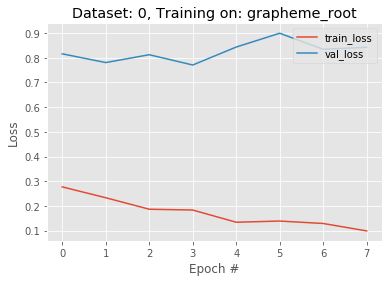

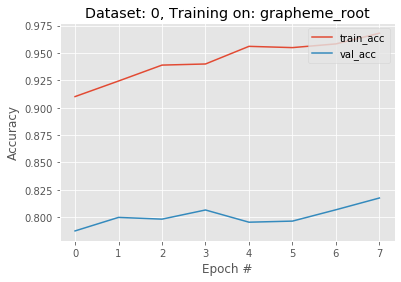

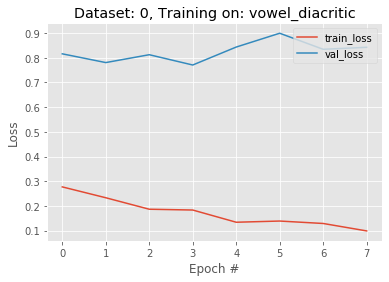

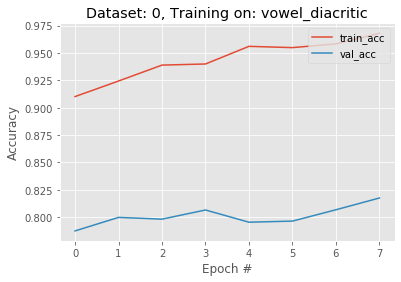

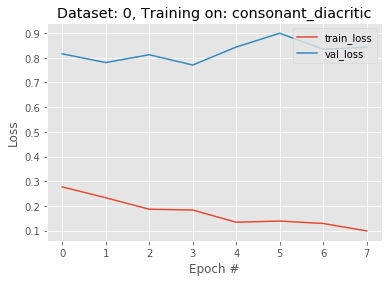

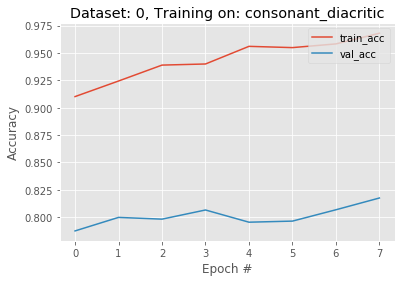

In [40]:
%matplotlib inline
def plot_loss(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['val_loss'], label='val_loss')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['acc'], label='train_acc')
    plt.plot(np.arange(0, epoch), his.history['val_acc'], label='val_acc')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()

for dataset in range(1):
    for target in ['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']:
        plot_loss(histories[0], epochs, f'Dataset: {dataset}, Training on: {target}')
        plot_acc(histories[0], epochs, f'Dataset: {dataset}, Training on: {target}')

Plots of model training history using Tensorboard.dev are showed below.

In [43]:
# Save model
model_name = 'resnet_model_root.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model_root.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/resnet_model_root.h5 


In [0]:
# Test Data
dict_pred = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}
components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
target=[] # model predictions placeholder
row_id=[] # row_id place holder
for i in range(4):
    df_test_img = pd.read_parquet(f'/content/bengali/test_image_data_{i}.parquet') 
    df_test_img.set_index('image_id', inplace=True)

    X_test = resize(df_test_img, need_progress_bar=False)/255
    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    preds = model.predict(X_test)

    for i, p in enumerate(dict_pred):
        dict_pred[p] = np.argmax(preds[i], axis=1)

    for k,id in enumerate(df_test_img.index.values):  
        for i,comp in enumerate(components):
            id_sample=id+'_'+comp
            row_id.append(id_sample)
            target.append(dict_pred[comp][k])
    del df_test_img
    del X_test
    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
df_sample.to_csv('submission.csv',index=False)
df_sample.head()

,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,3
2,Test_0_vowel_diacritic,0
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,93
